In [1]:
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
import matplotlib.pyplot as plt

import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Custom Anti Collision Tests openai gym environement

In [2]:
import gym
import gym_act

# Our Anti Collision Tests environement
env = gym.make("Act-v2")

ACT (Anti Collision Tests) with 10 cars using cv driver model
SEED 15438151168752304802


In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show_img(img):
    plt.imshow(img)
    plt.show()

# Replay Buffer

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN network: start experiments with a simple DNN

In [5]:
class DQN(nn.Module):

    def __init__(self, inputs=44, outputs=5):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# utility to conver numpy arrays to torch arrays 
# On GPU if possible, with floats 32 bits
def numpy_to_torch(state):
    s = torch.from_numpy(state).to(device)
    # unsqueeze(0) to add a batch dim
    s = s.unsqueeze(0).to(device).float()
    return s

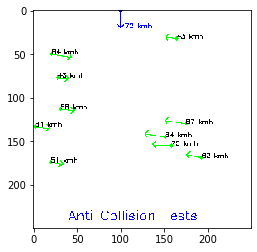

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get number of actions from gym action space
n_actions = env.action_space.n
action = 0
obs, reward, done, info = env.step(action)
env.reset()
img = env.render()
show_img(img)

n_feats = env.observation_space.shape[0] # ego [x,y,vx,vy] + 10 cars [x,y,vx,vy]
assert n_feats == 44 # should be 44 ...

policy_net = DQN(n_feats, n_actions).to(device)
target_net = DQN(n_feats, n_actions).to(device)

policy_net = policy_net.float()
target_net = target_net.float()

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
steps_done = 0

# Epsilon-greedy exploration

In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.argmax(policy_net(state)).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Optimize with Huber Loss

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    print("loss {}".format(loss))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


# Training example (on just a few episodes)

Some usefull references to follow up ideas and code:
* Playing Atari with Deep Reinforcement Learning, V. Mnih et al., NIPS Workshop, 2013:
  https://arxiv.org/abs/1312.5602  
* Human-level control through deep reinforcement learning, V. Mnih et al., Nature, 2015:  
  https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning  
* Automated Speed and Lane Change Decision Making using Deep Reinforcement Learning, Carl-Johan Hoel et al., ITSC, 2018:  
  https://arxiv.org/abs/1803.10056  
* Pytorch dqn starter code: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html  

We typically have to train for 10 million steps.  
But in this notebook, as an illustration, we just run for around 1000 steps.  
We confirm that this problem is much more difficult to solve than eg cartpole.  
And is not trivially solved or learned in a few minutes.  

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

res = 0
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = numpy_to_torch(state)
    cumulated_reward = 0
    images = []

    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, info = env.step(action.item())
        next_state = numpy_to_torch(next_state)
        cumulated_reward += reward
        print("Step {}: action={} reward={} done={} info={}".format(t, action, reward, done, info))
        img = env.render()
        images.append(img)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if done:
            #pdb.set_trace()
            next_state = None
            res += cumulated_reward
            print("End of episode {} with cumulated_reward {}".format(i_episode, cumulated_reward))

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            print('done!')
            #episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Completed with an average cumulated reward = {}'.format(res/num_episodes))
env.render()
env.close()

Step 0: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
Step 1: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
Step 2: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
Step 3: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
Step 4: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
Step 5: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
Step 6: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
Step 7: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
Step 8: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
Step 9: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
Step 10: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
Step 11: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
Step 12: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
Step 13: action=tensor

loss 33.951717376708984
Step 1: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 34.011756896972656
Step 2: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 33.84203338623047
Step 3: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 35.45830154418945
Step 4: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 34.70982360839844
Step 5: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 33.23237228393555
Step 6: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 19.01512336730957
Step 7: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 17.665681838989258
Step 8: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 33.60625076293945
Step 9: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 34.64080810546875
Step 10: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 33.48247146

Step 7: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 24.300020217895508
Step 8: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 32.127506256103516
Step 9: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 31.984844207763672
Step 10: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 16.210752487182617
Step 11: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 31.811765670776367
Step 12: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 24.343286514282227
Step 13: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 39.620445251464844
Step 14: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 32.212928771972656
Step 15: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 31.888620376586914
Step 16: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 16.519336700439453
Ste

Step 21: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 39.39434051513672
Step 22: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 16.115652084350586
Step 23: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 54.66499328613281
Step 24: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 63.344871520996094
Step 25: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 8.113483428955078
Step 26: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 31.663230895996094
Step 27: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 39.4349365234375
Step 28: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 31.552040100097656
Step 29: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 23.78714942932129
Step 30: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 23.848529815673828
Step 3

Step 35: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 21.97701644897461
Step 36: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 31.97949981689453
Step 37: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 23.523962020874023
Step 38: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 30.031461715698242
Step 39: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 16.372920989990234
Step 40: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 23.88108253479004
Step 41: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 16.234546661376953
Step 42: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 23.890514373779297
Step 43: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 47.1309928894043
Step 44: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 23.959592819213867
Step 

Step 0: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 39.53669738769531
Step 1: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 25.083236694335938
Step 2: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 62.231346130371094
Step 3: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 31.713634490966797
Step 4: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 40.549095153808594
Step 5: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 23.986454010009766
Step 6: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 39.43150329589844
Step 7: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 39.452091217041016
Step 8: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 54.71844482421875
Step 9: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 39.312259674072266
Step 10: acti

Step 62: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 31.79878807067871
Step 63: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 23.93617820739746
Step 64: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 47.11769104003906
Step 65: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 47.26475524902344
Step 66: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 39.693084716796875
Step 67: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 55.136287689208984
Step 68: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 24.079547882080078
Step 69: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 31.562580108642578
Step 70: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 31.4587459564209
Step 71: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 17.420166015625
Step 72: 

Step 45: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 8.444595336914062
Step 46: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 24.838590621948242
Step 47: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 39.49744415283203
Step 48: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 24.440204620361328
Step 49: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 40.50716781616211
Step 50: action=tensor([[3]], device='cuda:0') reward=999 done=True info=success
End of episode 29 with cumulated_reward 949
loss 16.77618980407715
done!
Step 0: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 39.619964599609375
Step 1: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 16.679100036621094
Step 2: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 23.513479232788086
Step 3: action=tensor([[1]], device='cuda:0') reward

loss 23.914142608642578
Step 3: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 19.16499900817871
Step 4: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 40.02125549316406
Step 5: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 15.843799591064453
Step 6: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 31.421884536743164
Step 7: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 31.432138442993164
Step 8: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 55.070335388183594
Step 9: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 23.95477867126465
Step 10: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 39.78545379638672
Step 11: action=tensor([[1]], device='cuda:0') reward=-1001 done=True info=fail
End of episode 35 with cumulated_reward -1012
loss 31.42518424987793
done!
Step 0: action=tensor([[3]], dev

Step 7: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 39.479862213134766
Step 8: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 8.553060531616211
Step 9: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 31.53338050842285
Step 10: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 16.26698112487793
Step 11: action=tensor([[2]], device='cuda:0') reward=-1001 done=True info=fail
End of episode 41 with cumulated_reward -1012
loss 8.063267707824707
done!
Step 0: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 31.783370971679688
Step 1: action=tensor([[3]], device='cuda:0') reward=-1 done=False info={}
loss 47.0386962890625
Step 2: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 16.348735809326172
Step 3: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 39.270233154296875
Step 4: action=tensor([[0]], device='cuda:0') reward=-1 d

Step 6: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 45.9075927734375
Step 7: action=tensor([[1]], device='cuda:0') reward=-1 done=False info={}
loss 15.053753852844238
Step 8: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 15.800653457641602
Step 9: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 7.963082790374756
Step 10: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 39.168968200683594
Step 11: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 55.29717254638672
Step 12: action=tensor([[0]], device='cuda:0') reward=-1 done=False info={}
loss 16.077983856201172
Step 13: action=tensor([[4]], device='cuda:0') reward=-1 done=False info={}
loss 24.105422973632812
Step 14: action=tensor([[2]], device='cuda:0') reward=-1 done=False info={}
loss 15.877126693725586
Step 15: action=tensor([[4]], device='cuda:0') reward=-1001 done=True info=fail
End of episode 48 with cumul

With just a few episodes of training, the trajectory is not collision free most of time. 

For a failure (collision) we get a reward of -1000 and end an episode.   
For a succes  (target reached) we get a reward of 999.  
**Average return after 100 episodes training: -509.18**